CV data preparation and dataset creation

In [23]:
import os
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


def train_preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize
    image = tf.image.random_flip_left_right(image)  # RandomHorizontalFlip(0.5)
    image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # Normalize
    return image, label


def val_preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize
    image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # Normalize
    return image, label


def load_and_preprocess_image(img_path, img_size):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalization
    return img


def create_dataset(data_dir, img_size=(128, 128)):
    images = []
    labels = []

    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            print(f"Processing class: {label}")  # Class name output
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                images.append(load_and_preprocess_image(img_path, img_size))
                labels.append(label)  # Add class label to the label list

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    return tf.data.Dataset.from_tensor_slices((images, labels_encoded))


# Upload data
dataset = create_dataset('Animal-10-split')

Processing class: butterfly
Processing class: cat
Processing class: chicken
Processing class: cow
Processing class: dog
Processing class: elephant
Processing class: horse
Processing class: sheep
Processing class: spider
Processing class: squirrel


CV data shuffling and data splitting

In [24]:
dataset = dataset.shuffle(buffer_size=10000)

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))  # 10% for validation
test_size = len(dataset) - train_size - val_size  # 10% for testing

train_dataset = dataset.take(train_size)  # Training dataset
validation_dataset = dataset.skip(train_size).take(val_size)  # Validation dataset
test_dataset = dataset.skip(train_size + val_size)  # Test dataset

# Pack data into batches
batch_size = 64
train_dataset = train_dataset.map(train_preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(val_preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(val_preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

CV model training

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Create callback for best model storage
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Path to saved model
    monitor='val_accuracy',  # Metrics to monitor
    save_best_only=True,  # Keep only the best model
    mode='max',  # Metric maximization
    verbose=1  # Display a save message
)

# Create callback for early stopping if model is not improving in 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrics to monitor
    patience=5,  # Number of epochs after which to stop learning if there has been no improvement
    mode='min',  # Metric minimization
    verbose=1  # Display stop message
)

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze model layers

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by 2 times (can be changed)
    patience=3,  # Wait for 3 epochs without improvement before reducing
    min_lr=1e-6,  # Minimum learning rate to not stop learning
    verbose=1  # Print messages to the console
)

unfreezed_layers_def = 40
dense_inner_layers_def = 512
dropout_def = 0.3
l2_value_def = 0.01
epochs_def = 10
learning_rate_def=0.005
momentum_def=0.9
weight_decay_def=0.0005

dense_inner_layers_input = input("Enter number of inner layers (default is 512): ")
dropout_input = input("Enter dropout value (default is 0.3): ")
l2_value_input = input("Enter l2 value (default is 0.01): ")
unfreezed_layers_input = input("Enter unfreezed layers number (default is 40): ")
epochs_input = input("Enter number of epochs (default is 10): ")
learning_rate_input = input("Enter learing rate (default is 0.005): ")
momentum_input = input("Enter momentum (default is 0.9): ")
weight_decay_input = input("Enter weight decay (default is 0.0005): ")

dense_inner_layers = int(dense_inner_layers_input) if dense_inner_layers_input else dense_inner_layers_def
dropout = float(dropout_input) if dropout_input else dropout_def
l2_value = float(l2_value_input) if l2_value_input else l2_value_def
unfreezed_layers = int(unfreezed_layers_input) if unfreezed_layers_input else unfreezed_layers_def
epochs = int(epochs_input) if epochs_input else epochs_def
learning_rate = float(learning_rate_input) if learning_rate_input else learning_rate_def
momentum = float(momentum_input) if momentum_input else momentum_def
weight_decay = float(weight_decay_input) if weight_decay_input else weight_decay_def

# Unfreeze top n layers
for layer in base_model.layers[-unfreezed_layers:]:
    layer.trainable = True

# Compose model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(dense_inner_layers, activation='relu', kernel_regularizer=l2(l2_value)),
    Dropout(dropout),
    Dense(10, activation='softmax')  # number of classes = 10 for Animal-10
])

# Compile model
model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)


Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5546 - loss: 8.3672    
Epoch 1: val_accuracy improved from -inf to 0.57012, saving model to best_model.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 915s 3s/step - accuracy: 0.5547 - loss: 8.3639 - val_accuracy: 0.5701 - val_loss: 5.6223 - learning_rate: 0.0050
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6881 - loss: 4.5999   
Epoch 2: val_accuracy improved from 0.57012 to 0.71609, saving model to best_model.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 909s 3s/step - accuracy: 0.6881 - loss: 4.5983 - val_accuracy: 0.7161 - val_loss: 3.0741 - learning_rate: 0.0050
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7204 - loss: 2.7344   
Epoch 3: val_accuracy improved from 0.71609 to 0.74627, saving model to best_model.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 880s 3s/step - accuracy: 0.7204 - loss: 2.7336 - val_accuracy: 0.7463 - val_loss: 1.9276 - learning_rate: 0.0050
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 2s

CV model testing

In [27]:
test_loss, test_accuracy = model.evaluate(test_dataset) # Model evaluation on test part of our dataset

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8866 - loss: 0.4087
Test Loss: 0.3994
Test Accuracy: 0.8900


NER data preparation

In [ ]:
from sklearn.model_selection import train_test_split
import json

# Read text data from file

with open('Animals in text train dataset.txt', 'r') as file:
    try:
        data = json.load(file)  # File parsing
    except json.JSONDecodeError as e:
        print(f"JSON error: {e}")

# Split into training (60%), validation (20%), and test (20%) data
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=42)  # 60% training, 40% remaining
val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                       random_state=42)  # 50% for validation and 50% for testing

NER model training

In [42]:
import spacy
from spacy.training import Example
import random

# Pre-trained nlp model loading
nlp = spacy.load("en_core_web_lg")

# Create NER component
ner = nlp.get_pipe("ner")

# Add labels to the NER
for item in train_data:
    for label in item['entities']:
        ner.add_label(label[2])

# Optimizer initialization
optimizer = nlp.create_optimizer()

# Learning parameters
n_iter_def = 30  # Epochs number
batch_size_def = 8  # Batch size
learning_rate_def = 0.0001  # Learning rate
dropout_rate_def = 0.1  # Dropout

n_iter_input = input(f"Enter number of epochs (default is 30): ")
batch_size_input = input(f"Enter batch size (default is 8): ")
learning_rate_input = input(f"Enter learning rate (default is 0.0001): ")
dropout_rate_input = input(f"Enter dropout rate (default is 0.1): ")

n_iter = int(n_iter_input) if n_iter_input else n_iter_def
batch_size = int(batch_size_input) if batch_size_input else batch_size_def
learning_rate = float(learning_rate_input) if learning_rate_input else learning_rate_def
dropout_rate = float(dropout_rate_input) if dropout_rate_input else dropout_rate_def

# Learning cycle
for epoch in range(n_iter):
    print(f"Epoch {epoch + 1}/{n_iter}")
    # Mix training data
    random.shuffle(train_data)

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]
        examples = []

        for item in batch:
            text = item['text']
            entities = [(ent[0], ent[1], ent[2]) for ent in item['entities']]

            # Create Doc object
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, {"entities": entities})
            examples.append(example)

        # Update model
        nlp.update(examples, drop=dropout_rate, losses={})

# Model storage
nlp.to_disk('trained_model')

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


NER model testing

In [43]:
# Load our trained NER model
nlp = spacy.load('trained_model')

# Calculation variables
total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0

# Evaluate model on test data
for item in test_data:
    text = item['text']
    true_entities = [(ent[0], ent[1], ent[2]) for ent in item['entities']]

    # Predict animals
    doc = nlp(text)
    predicted_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

    # Converting lists into sets for easier counting
    true_set = set(true_entities)
    pred_set = set(predicted_entities)

    # Calculate true positives, false positives, and false negatives
    true_positives = true_set.intersection(pred_set)
    false_positives = pred_set - true_set
    false_negatives = true_set - pred_set

    total_true_positives += len(true_positives)
    total_false_positives += len(false_positives)
    total_false_negatives += len(false_negatives)

# Calculating accuracy, recall, and F1
precision = total_true_positives / (total_true_positives + total_false_positives) if (
                                                                                             total_true_positives + total_false_positives) > 0 else 0
recall = total_true_positives / (total_true_positives + total_false_negatives) if (
                                                                                          total_true_positives + total_false_negatives) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8000
Recall: 0.5714
F1 Score: 0.6667


Animal image classification

In [10]:
import numpy as np
import tensorflow as tf

def train_cv_model_if_needed():
    cv_model_path = 'best_model.keras'
    if not os.path.exists(cv_model_path):
        print("CV model not found. Starting training...")
        subprocess.run(['python', 'cv_model_training.py'])
    return cv_model_path


# CV model loading
def load_cv_model():
    cv_model_path = train_cv_model_if_needed()
    return tf.keras.models.load_model(cv_model_path)


model = load_cv_model()

# Dictionary for converting labels into animal names
label_map = {
    0: 'cat',
    1: 'dog',
    2: 'cow',
    3: 'sheep',
    4: 'horse',
    5: 'elephant',
    6: 'spider',
    7: 'butterfly',
    8: 'chicken',
    9: 'squirrel'
}


def decode_predictions(predictions):
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class with the highest probability
    return label_map.get(predicted_class, "Unknown")  # Return the name of the animal or "Unknown"


def classify_animal(image_file):
    try:
        # Open the image with PIL
        image = Image.open(image_file)
        image = image.convert("RGB")  # Convert to RGB

        image = tf.image.resize(image, (128, 128))  # Resize
        image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # Normalize
        img_array = np.array(image)  # Convert to an array
        img_array = img_array / 255.0  # Normalizing pixel values

        img_array = np.expand_dims(img_array, axis=0)  # Adding a dimension for batch processing

        # Pass img_array to the model
        predictions = model.predict(img_array)
        return decode_predictions(predictions)  # Returning results
    except Exception as e:
        print(f"Error in classify_animal: {e}")
        return None

User text processing

In [3]:
def process_text(text, labels):
    nlp = spacy.load('trained_model')  # Loading our trained NER model
    doc = nlp(text)
    detected_animals = [ent.text for ent in doc.ents if ent.label_ in labels]
    return detected_animals

Pipeline assembling

In [7]:
import spacy
import os
import subprocess

global ner_model_path


def train_ner_model_if_needed():
    ner_model_path = 'trained_model'
    if not os.path.exists(ner_model_path):
        print("NER model not found. Starting training...")
        subprocess.run(['python', 'ner_model_training.py'])


def processing_pipeline():
    train_ner_model_if_needed()
    image_dir = input("Enter path to your image including image name or 'exit' to quit: ")
    if image_dir.lower() == 'exit':
        print("Exiting the program.")
        return
    text_data = input("Enter image description: ")
    print("Processing...")

    nlp = spacy.load(ner_model_path)
    ner = nlp.get_pipe("ner")
    labels = ner.labels

    # Text processing
    detected_animal = process_text(text_data, labels)

    # Images processing
    animal_from_image = classify_animal(image_dir)

    # Data comparing
    if detected_animal and animal_from_image:
        is_correct = detected_animal[0].lower() == animal_from_image.lower()
    else:
        is_correct = False  # If the animal is not identified from image or text

    print(is_correct)

    processing_pipeline()


if __name__ == '__main__':
    processing_pipeline()

Enter path to your image including image name or 'exit' to quit:  C:\Users\o.shcherbyna\PycharmProjects\Test DS project\Task2\Animal-10-split\elephant\e83cb60828f5043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg
Enter image description:  Ginger gorgeous elephant on photo.


Processing...
['elephant']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
elephant
True


Enter path to your image including image name or 'exit' to quit:  exit


Exiting the program.


Edge cases

1. Checking for Image Availability:

The code checks whether images are present in the class directory before processing them.

2. Handling Image Formats:

Exception handling is implemented when loading images to avoid errors with files that are not images.

3. Resizing Images:

All images are resized to a standard size to prevent issues with dimensions during training.

4. Label Validation:

The code checks that all labels in the training dataset are valid to avoid problems during model training.

5. Ignoring Classes with Insufficient Images:

If some classes have too few images, those classes may be ignored to prevent poor model performance.

6. Handling Missing Values in JSON:

The code checks for missing values in the JSON data and processes them accordingly.

7. Handling Label Collisions:

The code considers cases where the same image may have multiple labels to avoid confusion during training.

8. Checking File Path Validity:

The code checks whether the specified paths for image files and JSON are valid to avoid loading errors.

9. Optimizing Memory Usage:

tf.data.Dataset is used for streaming data loading to prevent memory issues when processing large datasets.

10. Validating Output Format for Predictions:

The code implements checks for the correctness of the data format passed to the decode_predictions function.

Little extra: web app for task 2

In [9]:
from flask import Flask, render_template, request
import spacy

app = Flask(__name__)  # Flask initialization


@app.route("/")
def home():
    return render_template('index.html')  # Display start page


@app.route("/process", methods=["POST"])
def process():
    train_ner_model_if_needed()
    if "file" not in request.files:  # Check if file is in the request
        return "No file part", 400  # If not - 404 error

    file = request.files["file"]
    if file.filename == "":  # Check if filename exists
        return "No selected file", 400  # If not - 404 error

    static_path = 'static/uploads'
    if not os.path.exists(static_path):
        os.makedirs(static_path)

    # File storage
    image_url = f"static/uploads/{file.filename}"
    file.save(image_url)

    text_data = request.form['description']  # Get the text from web form

    nlp = spacy.load('trained_model')
    ner = nlp.get_pipe("ner")
    labels = ner.labels

    # Text processing
    detected_animal = process_text(text_data.lower(), labels)

    # Image processing
    animal_from_image = classify_animal(image_url)

    # Data comparing
    if detected_animal and animal_from_image:
        is_correct = detected_animal[0].lower() == animal_from_image.lower()
    else:
        is_correct = False  # If the animal is not identified from image or text

    return render_template("result.html", image=image_url, text=text_data, result=is_correct)

In [ ]:
app.run(use_reloader=False, debug=False)

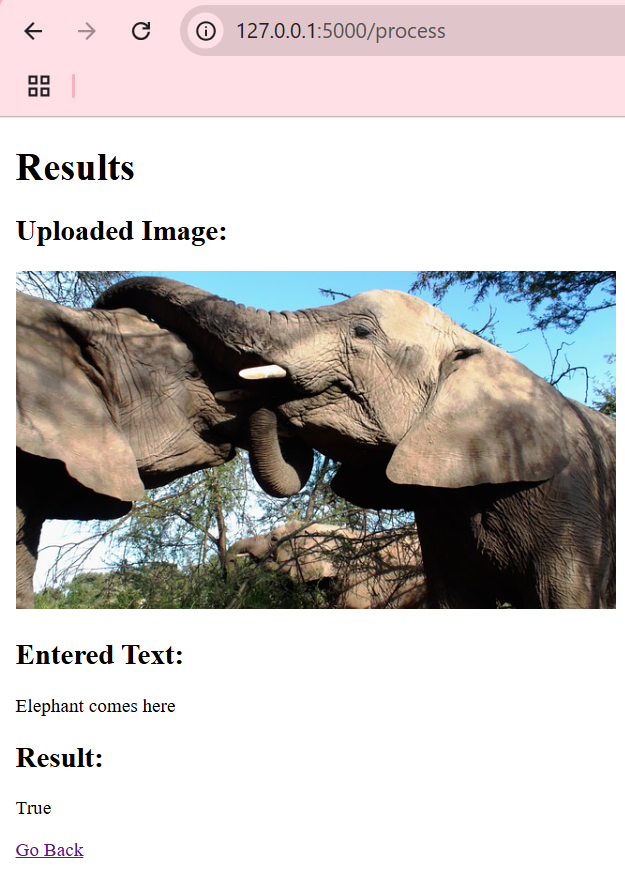

In [13]:
from IPython.display import Image

Image("img_3.png")